In [38]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [39]:
# -*- coding: utf-8 -*-
"""
Created on Sat Jan 11 04:13:14 2025

@author: phemb
"""

import numpy as np

class Generateur_Donnees:

    v = 20
    g = 0.1
    f_v = 0.001

    def __init__(self, vitesse_initiale = v, pesanteur = g, frottement_visqueux = f_v):

        self._v_0 = vitesse_initiale
        self._g = pesanteur
        self._f_v = frottement_visqueux

    def position_virtuelle(self,t):

        return np.where(- 0.5*self._g*t**2 + self._v_0 *t >= 0,- 0.5*self._g*t**2 + self._v_0 *t,0)

    def position_reelle(self,t):

        A = self._v_0/self._f_v + self._g/(self._f_v**2)
        B = - A

        return np.where(A+B*np.exp(-self._f_v*t)-(self._g/self._f_v)*t >= 0,A+B*np.exp(-self._f_v*t)-(self._g/self._f_v)*t,0)

    def set_vitesse_initiale(self,vitesse):

        self._v_0 = vitesse

    def set_pesanteur(self,coefficient):

        self._g = coefficient

    def set_frottement_visqueux(self,coefficient):

        self._f_v = coefficient

In [40]:
# --- MAIN: ÉTAPE 1 (Analyse & Visualisation) ---

# 1. Instanciation et génération
gen = Generateur_Donnees()

# On génère un temps suffisamment long pour voir la chute complète
# v0=20, g=0.1 -> temps de vol approx 400s
t = np.linspace(0, 450, 1000)

pos_virtuelle = gen.position_virtuelle(t)
pos_reelle = gen.position_reelle(t)

# 2. Calcul de l'Ignorance (La cible pour notre futur IA)
# Ignorance = Ce qui manque au modèle virtuel pour être égal au réel
ignorance = pos_reelle - pos_virtuelle



In [41]:
import plotly.graph_objects as go

fig_traj = go.Figure()

fig_traj.add_trace(
    go.Scatter(
        x=t,
        y=pos_virtuelle,
        name="Virtuel (Simplifié)",
        line=dict(dash='dash', color='blue')
    )
)

fig_traj.add_trace(
    go.Scatter(
        x=t,
        y=pos_reelle,
        name="Réel (Avec Frottement)",
        line=dict(color='green')
    )
)

fig_traj.update_layout(
    title="Comparaison des Trajectoires",
    xaxis_title="Temps (s)",
    yaxis_title="Hauteur (m)",
    hovermode="x unified",
    height=500
)

fig_traj.show()


In [42]:
fig_err = go.Figure()

fig_err.add_trace(
    go.Scatter(
        x=t,
        y=ignorance,
        name="Ignorance (Erreur)",
        line=dict(color='red')
    )
)

fig_err.update_layout(
    title="Visualisation de l'Ignorance (Erreur de Modélisation)",
    xaxis_title="Temps (s)",
    yaxis_title="Delta (m)",
    hovermode="x unified",
    height=500
)

fig_err.show()


In [43]:
# --- IMPORTS ---
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

# --- PRÉPARATION GLOBALE DES DONNÉES ---

# 1. Reshape
X = t.reshape(-1, 1)
y = ignorance

# 2. Split
# On sépare les données BRUTES. On ne scale pas encore.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Définition du Pipeline (La correction majeure)
# Au lieu de scaler manuellement X_train, on définit les étapes.
# Le scaler est intégré ici : il s'ajustera automatiquement sur chaque "fold" d'entraînement.
modele_pipeline = Pipeline([
    ('scaler', StandardScaler()),       # Étape 1 : Normalisation
    ('poly', PolynomialFeatures()),     # Étape 2 : Features polynomiales (si nécessaire)
    ('model', LinearRegression())       # Étape 3 : Le modèle (à changer selon besoin)
])

print(f"Données prêtes : {X_train.shape[0]} points d'entraînement, {X_test.shape[0]} points de test.")
print("Le scaling est désormais encapsulé dans 'modele_pipeline' pour éviter le data leakage.")

Données prêtes : 800 points d'entraînement, 200 points de test.
Le scaling est désormais encapsulé dans 'modele_pipeline' pour éviter le data leakage.


In [44]:
import plotly.graph_objects as go
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

print("--- i) Optimisation du modèle Polynomial ---")

# 1. OPTIMISATION (GridSearch)
# On teste les degrés de 1 à 6
param_grid = {'poly__degree': np.arange(1, 6)}

# On utilise le pipeline défini précédemment
# cv=5 : Validation croisée à 5 plis
grid_poly = GridSearchCV(modele_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# IMPORTANT : On fit sur X_train BRUT (le pipeline scalera tout seul)
grid_poly.fit(X_train, y_train)

best_degree = grid_poly.best_params_['poly__degree']
best_model_poly = grid_poly.best_estimator_
print(f"Meilleur degré trouvé : {best_degree}")



--- i) Optimisation du modèle Polynomial ---
Meilleur degré trouvé : 5


In [45]:

# 2. ÉVALUATION
# On prédit sur X_test BRUT
y_pred_poly = best_model_poly.predict(X_test)

rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))
r2_poly = r2_score(y_test, y_pred_poly)

# Erreur relative moyenne (ajout d'un epsilon pour éviter division par zéro)
epsilon = 1e-6
relative_error_poly = np.mean(np.abs(y_test - y_pred_poly) / (np.abs(y_test) + epsilon)) * 100

print(f"RMSE : {rmse_poly:.4f} m")
print(f"R2 Score : {r2_poly:.5f}")
print(f"Erreur Relative Moyenne : {relative_error_poly:.2f} %")


RMSE : 53.4177 m
R2 Score : 0.88840
Erreur Relative Moyenne : 1109049492.15 %


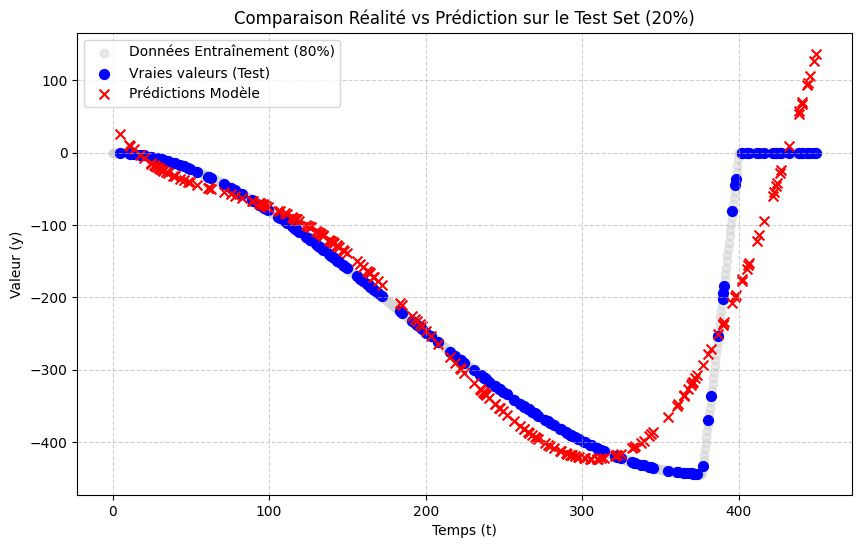

In [46]:
import matplotlib.pyplot as plt

# --- VISUALISATION ---
plt.figure(figsize=(10, 6))

# 1. On affiche les données d'entraînement en gris clair (pour le contexte)
plt.scatter(X_train, y_train, color='lightgray', label='Données Entraînement (80%)', alpha=0.5)

# 2. On affiche les VRAIES valeurs du set de test en Bleu
plt.scatter(X_test, y_test, color='blue', label='Vraies valeurs (Test)', s=50)

# 3. On affiche les valeurs PRÉDITES par ton modèle en Rouge
# On utilise un marqueur différent (ex: 'x') pour bien les distinguer si elles se chevauchent
plt.scatter(X_test, y_pred_poly, color='red', marker='x', label='Prédictions Modèle', s=50)

plt.title("Comparaison Réalité vs Prédiction sur le Test Set (20%)")
plt.xlabel("Temps (t)")
plt.ylabel("Valeur (y)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [47]:
# 3. TRACÉ (Validation Visuelle)
# On génère la prédiction sur tout l'axe t pour voir la courbe complète
# X est déjà défini (t.reshape(-1, 1))
ignorance_pred_full = best_model_poly.predict(X)
pos_hybride_poly = pos_virtuelle + ignorance_pred_full

fig_poly = go.Figure()

# A. Modèle Virtuel
fig_poly.add_trace(go.Scatter(x=t, y=pos_virtuelle, name="Virtuel", line=dict(dash='dash', color='blue')))

# B. Réalité (Target)
fig_poly.add_trace(go.Scatter(x=t, y=pos_reelle, name="Réel (Target)", line=dict(color='green', width=4), opacity=0.4))

# C. Hybride (Polynomial)
fig_poly.add_trace(go.Scatter(x=t, y=pos_hybride_poly, name=f"Hybride (Poly deg={best_degree})", line=dict(dash='dot', color='red')))

fig_poly.update_layout(
    title=f"Validation Régression Polynomiale (Degré {best_degree})<br>RMSE={rmse_poly:.2f}m | R2={r2_poly:.4f}",
    xaxis_title="Temps (s)",
    yaxis_title="Position (m)",
    hovermode="x unified"
)
fig_poly.show()

In [48]:
# --- 3. TRACÉ MODIFIÉ (Comparaison des Ignorances) ---
# On génère la prédiction sur tout l'axe t pour voir la courbe complète
# X est déjà défini (t.reshape(-1, 1))

fig_ign_poly = go.Figure()

# A. Ignorance Réelle (Target)
# C'est la vérité terrain que le modèle essaie d'atteindre
fig_ign_poly.add_trace(go.Scatter(
    x=t,
    y=ignorance, # C'est votre variable 'ignorance' calculée au début
    name="Ignorance Réelle (Target)",
    line=dict(color='red', width=4),
    opacity=0.5
))

# B. Ignorance Prédite (Polynomial)
# C'est ce que le modèle a compris
fig_ign_poly.add_trace(go.Scatter(
    x=t,
    y=ignorance_pred_full,
    name=f"Ignorance Prédite (Poly deg={best_degree})",
    line=dict(dash='dot', color='blue', width=2)
))

fig_ign_poly.update_layout(
    title=f"Validation du Modèle : Comparaison des Ignorances (Degré {best_degree})<br>RMSE sur le Test={rmse_poly:.2f}m",
    xaxis_title="Temps (s)",
    yaxis_title="Ignorance (mètres)",
    hovermode="x unified"
)

fig_ign_poly.show()

XGBOOST

In [23]:
# --- IMPORTS ---
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
import xgboost as xgb
import numpy as np

# --- PRÉPARATION GLOBALE DES DONNÉES (Rappel) ---
# X et y sont supposés existants (t.reshape(-1, 1) et ignorance)
# On s'assure d'avoir le même split pour comparer équitablement
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Définition du Pipeline XGBoost
# Pas de 'poly' ici, XGBoost apprend les non-linéarités via ses arbres
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),       # Étape 1 : Normalisation (aide à la convergence)
    ('model', xgb.XGBRegressor(objective='reg:squarederror', random_state=42)) # Étape 2 : Le modèle XGBoost
])

print(f"Pipeline XGBoost prêt.")

Pipeline XGBoost prêt.


In [24]:
import plotly.graph_objects as go
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

print("--- ii) Optimisation du modèle XGBoost ---")

# 1. OPTIMISATION (GridSearch)
# On teste le nombre d'arbres et leur profondeur
param_grid_xgb = {
    'model__n_estimators': [50, 100, 200], # Nombre d'arbres
    'model__max_depth': [3, 5, 7],         # Complexité de chaque arbre
    'model__learning_rate': [0.01, 0.1]    # Vitesse d'apprentissage
}

# cv=5 : Validation croisée à 5 plis
grid_xgb = GridSearchCV(xgb_pipeline, param_grid_xgb, cv=5, scoring='neg_mean_squared_error')

# On fit sur X_train (le pipeline gère le scaling)
grid_xgb.fit(X_train, y_train)

best_params_xgb = grid_xgb.best_params_
best_model_xgb = grid_xgb.best_estimator_

print(f"Meilleurs paramètres trouvés : {best_params_xgb}")

--- ii) Optimisation du modèle XGBoost ---
Meilleurs paramètres trouvés : {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 200}


In [25]:
# 2. ÉVALUATION
# On prédit sur X_test BRUT
y_pred_xgb = best_model_xgb.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

# Erreur relative moyenne
epsilon = 1e-6
relative_error_xgb = np.mean(np.abs(y_test - y_pred_xgb) / (np.abs(y_test) + epsilon)) * 100

print(f"RMSE : {rmse_xgb:.4f} m")
print(f"R2 Score : {r2_xgb:.5f}")
print(f"Erreur Relative Moyenne : {relative_error_xgb:.2f} %")

RMSE : 2.2223 m
R2 Score : 0.99981
Erreur Relative Moyenne : 18446.29 %


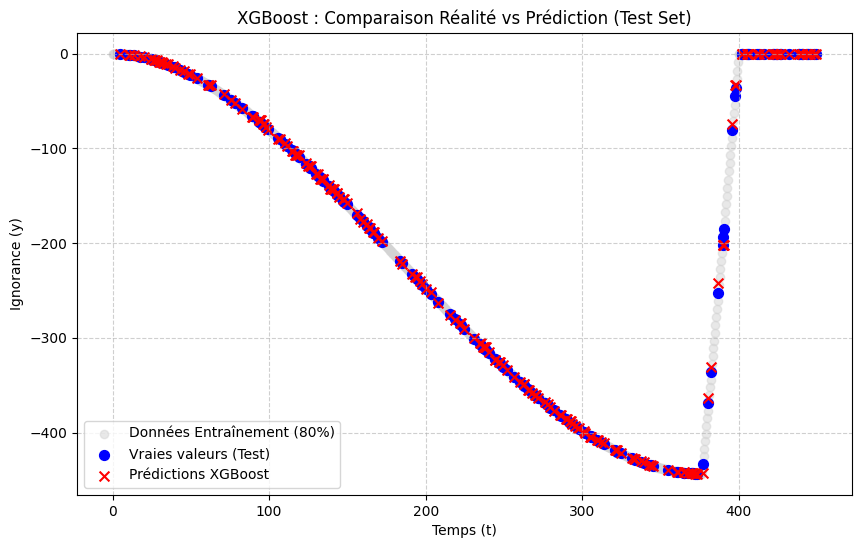

In [26]:
import matplotlib.pyplot as plt

# --- VISUALISATION ---
plt.figure(figsize=(10, 6))

# 1. Données d'entraînement (Contexte)
plt.scatter(X_train, y_train, color='lightgray', label='Données Entraînement (80%)', alpha=0.5)

# 2. Vraies valeurs (Test)
plt.scatter(X_test, y_test, color='blue', label='Vraies valeurs (Test)', s=50)

# 3. Prédictions XGBoost
plt.scatter(X_test, y_pred_xgb, color='red', marker='x', label='Prédictions XGBoost', s=50)

plt.title("XGBoost : Comparaison Réalité vs Prédiction (Test Set)")
plt.xlabel("Temps (t)")
plt.ylabel("Ignorance (y)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [27]:
# 3. TRACÉ (Validation Visuelle Trajectoire)
# On génère la prédiction sur tout l'axe t
ignorance_pred_full_xgb = best_model_xgb.predict(X)
pos_hybride_xgb = pos_virtuelle + ignorance_pred_full_xgb

fig_xgb = go.Figure()

# A. Modèle Virtuel
fig_xgb.add_trace(go.Scatter(x=t, y=pos_virtuelle, name="Virtuel", line=dict(dash='dash', color='blue')))

# B. Réalité (Target)
fig_xgb.add_trace(go.Scatter(x=t, y=pos_reelle, name="Réel (Target)", line=dict(color='green', width=4), opacity=0.4))

# C. Hybride (XGBoost)
# On récupère les params pour le label (ex: n_estimators)
n_est = best_params_xgb['model__n_estimators']
fig_xgb.add_trace(go.Scatter(x=t, y=pos_hybride_xgb, name=f"Hybride (XGBoost n={n_est})", line=dict(dash='dot', color='red')))

fig_xgb.update_layout(
    title=f"Validation XGBoost<br>RMSE={rmse_xgb:.2f}m | R2={r2_xgb:.4f}",
    xaxis_title="Temps (s)",
    yaxis_title="Position (m)",
    hovermode="x unified"
)
fig_xgb.show()

In [28]:
# --- 3. TRACÉ MODIFIÉ (Comparaison des Ignorances XGBoost) ---

fig_ign_xgb = go.Figure()

# A. Ignorance Réelle
fig_ign_xgb.add_trace(go.Scatter(
    x=t,
    y=ignorance,
    name="Ignorance Réelle (Target)",
    line=dict(color='red', width=4),
    opacity=0.5
))

# B. Ignorance Prédite (XGBoost)
fig_ign_xgb.add_trace(go.Scatter(
    x=t,
    y=ignorance_pred_full_xgb,
    name=f"Ignorance Prédite (XGBoost)",
    line=dict(dash='dot', color='blue', width=2)
))

fig_ign_xgb.update_layout(
    title=f"Validation XGBoost : Comparaison des Ignorances<br>RMSE sur le Test={rmse_xgb:.2f}m",
    xaxis_title="Temps (s)",
    yaxis_title="Ignorance (mètres)",
    hovermode="x unified"
)

fig_ign_xgb.show()

MLP

In [29]:
# --- IMPORTS ---
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
import numpy as np

# --- PRÉPARATION GLOBALE (Rappel) ---
# X_train, X_test, y_train, y_test existent déjà (séparés sans scaling)

# 3. Définition du Pipeline MLP
# StandardScaler est CRUCIAL pour les réseaux de neurones
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Étape 1 : Normalisation (Indispensable)
    ('model', MLPRegressor(random_state=42, solver='adam')) # Étape 2 : Le MLP
])

print("Pipeline MLP prêt.")

Pipeline MLP prêt.


In [30]:
import plotly.graph_objects as go
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

print("--- iii) Optimisation du modèle MLP ---")

# 1. OPTIMISATION
param_grid_mlp = {
    # On teste votre architecture cible et quelques variantes
    'model__hidden_layer_sizes': [(64, 64, 32), (64, 32)],
    'model__activation': ['relu', 'tanh'],  # 'tanh' donne souvent des courbes plus lisses pour la physique
    'model__alpha': [0.0001, 0.001],        # Régularisation L2
    'model__max_iter': [1000]               # Assez d'itérations pour converger
}

grid_mlp = GridSearchCV(mlp_pipeline, param_grid_mlp, cv=5, scoring='neg_mean_squared_error')
grid_mlp.fit(X_train, y_train)

best_params_mlp = grid_mlp.best_params_
best_model_mlp = grid_mlp.best_estimator_

print(f"Meilleurs paramètres trouvés : {best_params_mlp}")

--- iii) Optimisation du modèle MLP ---


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Max

Meilleurs paramètres trouvés : {'model__activation': 'relu', 'model__alpha': 0.001, 'model__hidden_layer_sizes': (64, 64, 32), 'model__max_iter': 1000}


In [31]:
import joblib

# On sauvegarde le "best_estimator_" qui contient le Pipeline complet (Scaler + MLP entraîné)
filename = 'modele_mlp_optimal.pkl'
joblib.dump(best_model_mlp, filename)

print(f"Modèle sauvegardé avec succès sous le nom : {filename}")

Modèle sauvegardé avec succès sous le nom : modele_mlp_optimal.pkl


In [32]:
# 2. ÉVALUATION
y_pred_mlp = best_model_mlp.predict(X_test)

rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred_mlp))
r2_mlp = r2_score(y_test, y_pred_mlp)

epsilon = 1e-6
relative_error_mlp = np.mean(np.abs(y_test - y_pred_mlp) / (np.abs(y_test) + epsilon)) * 100

print(f"RMSE : {rmse_mlp:.4f} m")
print(f"R2 Score : {r2_mlp:.5f}")
print(f"Erreur Relative Moyenne : {relative_error_mlp:.2f} %")

RMSE : 3.7554 m
R2 Score : 0.99945
Erreur Relative Moyenne : 73763704.34 %


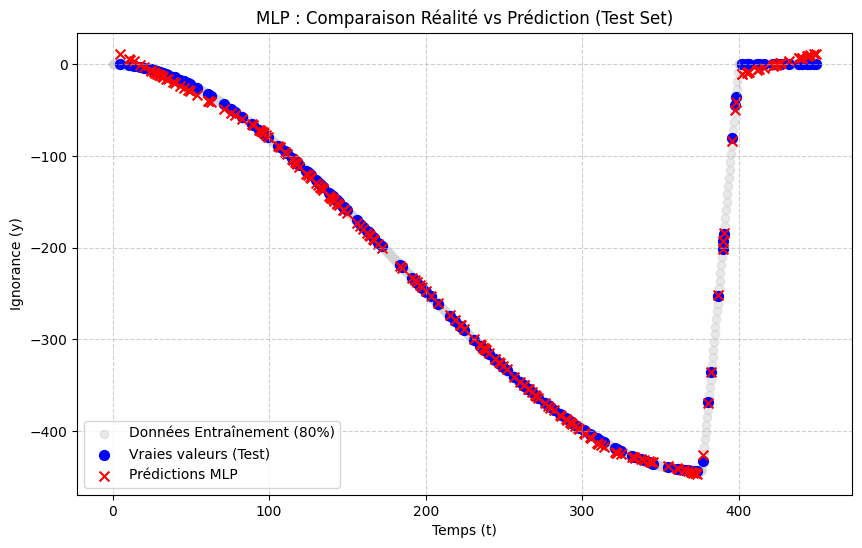

In [33]:
import matplotlib.pyplot as plt

# --- VISUALISATION SCATTER ---
plt.figure(figsize=(10, 6))

plt.scatter(X_train, y_train, color='lightgray', label='Données Entraînement (80%)', alpha=0.5)
plt.scatter(X_test, y_test, color='blue', label='Vraies valeurs (Test)', s=50)
plt.scatter(X_test, y_pred_mlp, color='red', marker='x', label='Prédictions MLP', s=50)

plt.title("MLP : Comparaison Réalité vs Prédiction (Test Set)")
plt.xlabel("Temps (t)")
plt.ylabel("Ignorance (y)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [34]:
# 3. TRACÉ TRAJECTOIRE
# Prédiction sur tout l'axe t
ignorance_pred_full_mlp = best_model_mlp.predict(X)
pos_hybride_mlp = pos_virtuelle + ignorance_pred_full_mlp

fig_mlp = go.Figure()

# A. Modèle Virtuel
fig_mlp.add_trace(go.Scatter(x=t, y=pos_virtuelle, name="Virtuel", line=dict(dash='dash', color='blue')))

# B. Réalité (Target)
fig_mlp.add_trace(go.Scatter(x=t, y=pos_reelle, name="Réel (Target)", line=dict(color='green', width=4), opacity=0.4))

# C. Hybride (MLP)
arch = best_params_mlp['model__hidden_layer_sizes']
act = best_params_mlp['model__activation']
fig_mlp.add_trace(go.Scatter(x=t, y=pos_hybride_mlp, name=f"Hybride (MLP {arch} - {act})", line=dict(dash='dot', color='red')))

fig_mlp.update_layout(
    title=f"Validation MLP<br>RMSE={rmse_mlp:.2f}m | R2={r2_mlp:.4f}",
    xaxis_title="Temps (s)",
    yaxis_title="Position (m)",
    hovermode="x unified"
)
fig_mlp.show()

In [35]:
# --- 3. TRACÉ IGNORANCE ---

fig_ign_mlp = go.Figure()

# A. Ignorance Réelle
fig_ign_mlp.add_trace(go.Scatter(
    x=t,
    y=ignorance,
    name="Ignorance Réelle (Target)",
    line=dict(color='red', width=4),
    opacity=0.5
))

# B. Ignorance Prédite (MLP)
fig_ign_mlp.add_trace(go.Scatter(
    x=t,
    y=ignorance_pred_full_mlp,
    name=f"Ignorance Prédite (MLP)",
    line=dict(dash='dot', color='blue', width=2)
))

fig_ign_mlp.update_layout(
    title=f"Validation MLP : Comparaison des Ignorances<br>RMSE sur le Test={rmse_mlp:.2f}m",
    xaxis_title="Temps (s)",
    yaxis_title="Ignorance (mètres)",
    hovermode="x unified"
)

fig_ign_mlp.show()

## Configuration non figée

In [73]:
import numpy as np
from sklearn.model_selection import train_test_split

# 1. Instanciation
gen = Generateur_Donnees()

# 2. Paramètres de génération
nb_scenarios = 500  # On augmente un peu pour bien couvrir l'espace 4D
points_par_scenario = 100
t_span = np.linspace(0, 600, points_par_scenario) # On prend une plage large

X_data = []
y_data = []

np.random.seed(42) # Pour la reproductibilité

print("Génération des données variées en cours...")

for _ in range(nb_scenarios):
    # Tirage aléatoire des paramètres physiques
    v = np.random.uniform(10, 50)
    g = np.random.uniform(0.05, 0.2)
    f = np.random.uniform(0.0005, 0.005)

    # Configuration du générateur
    gen.set_vitesse_initiale(v)
    gen.set_pesanteur(g)
    gen.set_frottement_visqueux(f)

    # Calcul des trajectoires
    pos_v = gen.position_virtuelle(t_span)
    pos_r = gen.position_reelle(t_span)
    ignorance = pos_r - pos_v # CIBLE

    # Remplissage des listes
    # X doit contenir 4 colonnes : [t, v0, g, fv]
    for k in range(len(t_span)):
        # On ne garde que les points où la balle est en l'air (pos > 0) ou juste au sol
        # pour éviter d'apprendre trop de zéros inutiles, mais ici on garde tout pour simplifier
        X_data.append([t_span[k], v, g, f])
        y_data.append(ignorance[k])

X_array = np.array(X_data)
y_array = np.array(y_data)

# 3. Split Train/Test
# Cette fois, le Test Set contient aussi des paramètres variés !
X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, test_size=0.2, random_state=42)

print(f"Base de données générée :")
print(f"- X_train : {X_train.shape}")
print(f"- X_test  : {X_test.shape} (Contient des configs variées)")

Génération des données variées en cours...
Base de données générée :
- X_train : (40000, 4)
- X_test  : (10000, 4) (Contient des configs variées)


Polynomiales

In [50]:
# --- CELLULE 1 : Pipeline Polynomial ---
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import numpy as np

# Note : X_train et X_test (qui contiennent 4 colonnes) ont été créés dans l'étape précédente

# Définition du Pipeline
# Le modèle va devoir combiner t, v, g et f pour trouver la formule
modele_pipeline_poly = Pipeline([
    ('scaler', StandardScaler()),       # Important pour mettre t (0-600) et f (0.001) à la même échelle
    ('poly', PolynomialFeatures()),     # Génère les interactions (t*v, t^2, v^2, etc.)
    ('model', LinearRegression())
])

print("Pipeline Polynomial (Multi-variables) prêt.")

Pipeline Polynomial (Multi-variables) prêt.


In [51]:
# --- CELLULE 2 : Optimisation ---
print("--- i) Optimisation Polynomiale (Multi-variables) ---")

# On limite le degré car avec 4 variables, le nombre de coefficients explose vite
# Degré 4 avec 4 vars = 70 features. Degré 6 = 210 features.
param_grid = {'poly__degree': [1, 2, 3, 4, 5, 6]}

grid_poly = GridSearchCV(modele_pipeline_poly, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_poly.fit(X_train, y_train)

best_degree = grid_poly.best_params_['poly__degree']
best_model_poly = grid_poly.best_estimator_

print(f"Meilleur degré trouvé pour généraliser : {best_degree}")

--- i) Optimisation Polynomiale (Multi-variables) ---
Meilleur degré trouvé pour généraliser : 6


In [52]:
# --- CELLULE 3 : Évaluation ---
from sklearn.metrics import mean_squared_error, r2_score

y_pred_poly = best_model_poly.predict(X_test)

rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))
r2_poly = r2_score(y_test, y_pred_poly)

epsilon = 1e-6
relative_error_poly = np.mean(np.abs(y_test - y_pred_poly) / (np.abs(y_test) + epsilon)) * 100

print(f"RMSE Global : {rmse_poly:.4f} m")
print(f"R2 Score Global : {r2_poly:.5f}")
print(f"Erreur Relative Moyenne : {relative_error_poly:.2f} %")

RMSE Global : 246.5759 m
R2 Score Global : 0.98153
Erreur Relative Moyenne : 5411315692.98 %


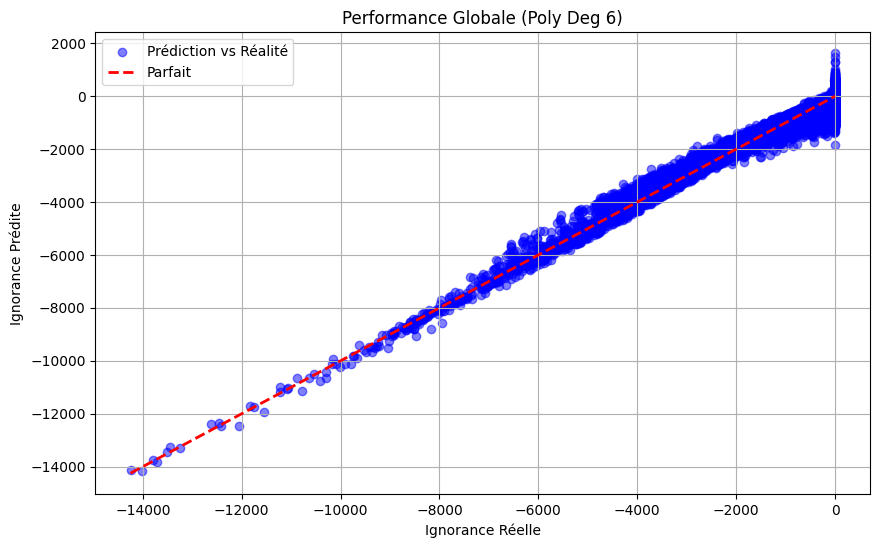

In [57]:
# --- CELLULE 4 : Scatter Plot ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
subset = np.random.choice(len(y_test), 10000, replace=False)

plt.scatter(y_test[subset], y_pred_poly[subset], alpha=0.5, color='blue', label='Prédiction vs Réalité')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Parfait')

plt.title(f"Performance Globale (Poly Deg {best_degree})")
plt.xlabel("Ignorance Réelle")
plt.ylabel("Ignorance Prédite")
plt.legend()
plt.grid(True)
plt.show()

In [55]:
# --- CELLULE 5 : Validation sur une Trajectoire Inédite ---
import plotly.graph_objects as go

# 1. Création d'un scénario test spécifique (jamais vu par le modèle)
gen_visu = Generateur_Donnees()
v_visu, g_visu, f_visu = 45, 0.15, 0.003 # Une config "difficile" (haute vitesse, fort frottement)
gen_visu.set_vitesse_initiale(v_visu)
gen_visu.set_pesanteur(g_visu)
gen_visu.set_frottement_visqueux(f_visu)

t_visu = np.linspace(0, 600, 600)
pos_v_visu = gen_visu.position_virtuelle(t_visu)
pos_r_visu = gen_visu.position_reelle(t_visu)

# 2. Préparation des features pour la prédiction [t, v, g, f]
X_visu = np.column_stack((
    t_visu,
    np.full_like(t_visu, v_visu),
    np.full_like(t_visu, g_visu),
    np.full_like(t_visu, f_visu)
))

# 3. Prédiction
ignorance_pred_visu = best_model_poly.predict(X_visu)
pos_hybride_visu = pos_v_visu + ignorance_pred_visu

# 4. Plot
fig_poly = go.Figure()
fig_poly.add_trace(go.Scatter(x=t_visu, y=pos_v_visu, name="Virtuel", line=dict(dash='dash', color='blue')))
fig_poly.add_trace(go.Scatter(x=t_visu, y=pos_r_visu, name="Réel (Target)", line=dict(color='green', width=4), opacity=0.4))
fig_poly.add_trace(go.Scatter(x=t_visu, y=pos_hybride_visu, name=f"Hybride (Poly)", line=dict(dash='dot', color='red')))

fig_poly.update_layout(title=f"Test de Généralisation : Scénario Inédit (v={v_visu}, g={g_visu}, f={f_visu})", xaxis_title="Temps (s)", yaxis_title="Position (m)")
fig_poly.show()

In [56]:
# --- CELLULE 6 : Ignorance sur Scénario Inédit ---

fig_ign_poly = go.Figure()

# Ignorance Réelle
ignorance_reelle_visu = pos_r_visu - pos_v_visu

fig_ign_poly.add_trace(go.Scatter(
    x=t_visu,
    y=ignorance_reelle_visu,
    name="Ignorance Réelle",
    line=dict(color='red', width=4),
    opacity=0.5
))

# Ignorance Prédite
fig_ign_poly.add_trace(go.Scatter(
    x=t_visu,
    y=ignorance_pred_visu,
    name="Ignorance Prédite (Poly)",
    line=dict(dash='dot', color='blue', width=2)
))

fig_ign_poly.update_layout(
    title=f"Zoom sur l'Ignorance (Scénario Inédit)",
    xaxis_title="Temps (s)",
    yaxis_title="Ignorance (m)",
    hovermode="x unified"
)
fig_ign_poly.show()

XGBoost

In [58]:
# --- CELLULE 1 : Pipeline XGBoost (Généralisation) ---
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import numpy as np

# Définition du Pipeline
# Le modèle va apprendre la physique globale sur 4 variables
modele_pipeline_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('model', xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42))
])

print("Pipeline XGBoost (Multi-variables) prêt.")

Pipeline XGBoost (Multi-variables) prêt.


In [59]:
# --- CELLULE 2 : Optimisation ---
print("--- ii) Optimisation XGBoost (Multi-variables) ---")

# Paramètres adaptés pour une régression physique 4D
param_grid_xgb = {
    'model__n_estimators': [100, 300],      # Assez d'arbres pour être précis
    'model__max_depth': [5, 7, 9],          # Profondeur pour capturer les interactions complexes
    'model__learning_rate': [0.05, 0.1]     # Vitesse d'apprentissage standard
}

grid_xgb = GridSearchCV(modele_pipeline_xgb, param_grid_xgb, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_xgb.fit(X_train, y_train)

best_params_xgb = grid_xgb.best_params_
best_model_xgb = grid_xgb.best_estimator_

print(f"Meilleurs paramètres trouvés : {best_params_xgb}")

--- ii) Optimisation XGBoost (Multi-variables) ---
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Meilleurs paramètres trouvés : {'model__learning_rate': 0.1, 'model__max_depth': 9, 'model__n_estimators': 300}


In [60]:
# --- CELLULE 3 : Évaluation ---
from sklearn.metrics import mean_squared_error, r2_score

y_pred_xgb = best_model_xgb.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

epsilon = 1e-6
relative_error_xgb = np.mean(np.abs(y_test - y_pred_xgb) / (np.abs(y_test) + epsilon)) * 100

print(f"RMSE Global : {rmse_xgb:.4f} m")
print(f"R2 Score Global : {r2_xgb:.5f}")
print(f"Erreur Relative Moyenne : {relative_error_xgb:.2f} %")

RMSE Global : 46.1773 m
R2 Score Global : 0.99935
Erreur Relative Moyenne : 337300219.65 %


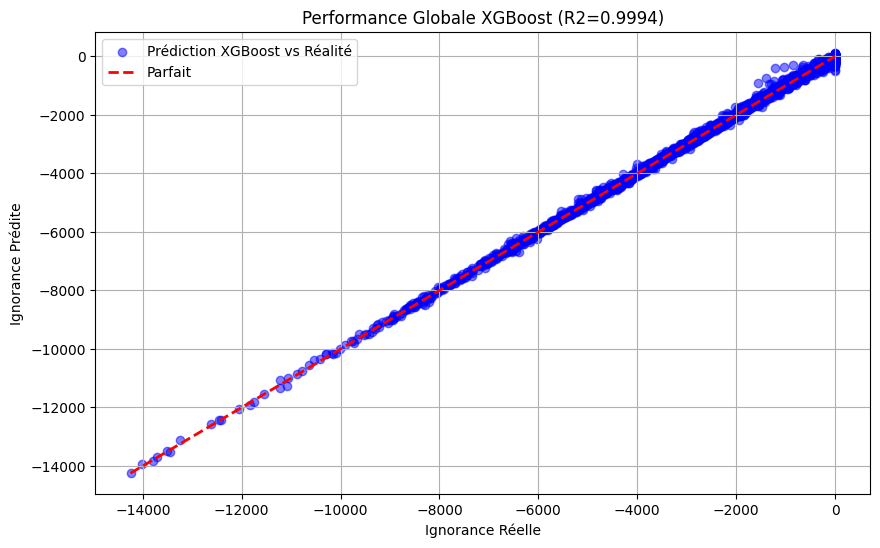

In [64]:
# --- CELLULE 4 : Scatter Plot ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# Échantillonnage pour lisibilité
subset = np.random.choice(len(y_test), 10000, replace=False)

plt.scatter(y_test[subset], y_pred_xgb[subset], alpha=0.5, color='blue', label='Prédiction XGBoost vs Réalité')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Parfait')

plt.title(f"Performance Globale XGBoost (R2={r2_xgb:.4f})")
plt.xlabel("Ignorance Réelle")
plt.ylabel("Ignorance Prédite")
plt.legend()
plt.grid(True)
plt.show()

In [63]:
# --- CELLULE 5 : Validation sur une Trajectoire Inédite ---
import plotly.graph_objects as go

# 1. On reprend le même scénario "visu" défini précédemment (cellule 5 de la partie polynomiale)
# X_visu contient déjà les données pour v=45, g=0.15, f=0.003
# Si X_visu n'est plus en mémoire, ré-exécutez la définition de la partie précédente ou celle-ci :
# --- Rappel définition si besoin ---
v_visu, g_visu, f_visu = 45, 0.15, 0.003
t_visu = np.linspace(0, 600, 600)
X_visu = np.column_stack((t_visu, np.full_like(t_visu, v_visu), np.full_like(t_visu, g_visu), np.full_like(t_visu, f_visu)))
gen_visu = Generateur_Donnees(v_visu, g_visu, f_visu)
pos_v_visu = gen_visu.position_virtuelle(t_visu)
pos_r_visu = gen_visu.position_reelle(t_visu)
# -----------------------------------

# 2. Prédiction
ignorance_pred_visu_xgb = best_model_xgb.predict(X_visu)
pos_hybride_visu_xgb = pos_v_visu + ignorance_pred_visu_xgb

# 3. Plot
fig_xgb = go.Figure()
fig_xgb.add_trace(go.Scatter(x=t_visu, y=pos_v_visu, name="Virtuel", line=dict(dash='dash', color='blue')))
fig_xgb.add_trace(go.Scatter(x=t_visu, y=pos_r_visu, name="Réel (Target)", line=dict(color='green', width=4), opacity=0.4))
fig_xgb.add_trace(go.Scatter(x=t_visu, y=pos_hybride_visu_xgb, name=f"Hybride (XGBoost)", line=dict(dash='dot', color='red')))

fig_xgb.update_layout(title=f"Test de Généralisation XGBoost : Scénario Inédit", xaxis_title="Temps (s)", yaxis_title="Position (m)")
fig_xgb.show()

In [65]:
# --- CELLULE 6 : Ignorance sur Scénario Inédit ---

fig_ign_xgb = go.Figure()

# Ignorance Réelle
ignorance_reelle_visu = pos_r_visu - pos_v_visu

fig_ign_xgb.add_trace(go.Scatter(
    x=t_visu,
    y=ignorance_reelle_visu,
    name="Ignorance Réelle",
    line=dict(color='red', width=4),
    opacity=0.5
))

# Ignorance Prédite
fig_ign_xgb.add_trace(go.Scatter(
    x=t_visu,
    y=ignorance_pred_visu_xgb,
    name="Ignorance Prédite (XGBoost)",
    line=dict(dash='dot', color='blue', width=2)
))

fig_ign_xgb.update_layout(
    title=f"Zoom sur l'Ignorance XGBoost (Scénario Inédit)",
    xaxis_title="Temps (s)",
    yaxis_title="Ignorance (m)",
    hovermode="x unified"
)
fig_ign_xgb.show()

MLP

In [74]:
# --- CELLULE 1 : Pipeline MLP (Généralisation) ---
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import numpy as np

# Définition du Pipeline
modele_pipeline_mlp = Pipeline([
    ('scaler', StandardScaler()),       # Indispensable pour que le réseau apprenne vite
    ('model', MLPRegressor(random_state=42, solver='adam'))
])

print("Pipeline MLP (Multi-variables) prêt.")

Pipeline MLP (Multi-variables) prêt.


In [76]:
# --- CELLULE 2 : Entraînement Direct (Sans GridSearch inutile) ---
print("--- iii) Entraînement MLP (Configuration Optimale Partie 1) ---")

# On reprend directement les paramètres gagnants de la Partie 1
# Cela évite de lancer 24 entraînements inutiles
params_optimaux = {
    'hidden_layer_sizes': (64, 64, 32), # L'architecture validée
    'activation': 'relu',
    'alpha': 0.001,
    'solver': 'adam',
    'max_iter': 1000,
    'random_state': 42
}

# On configure le modèle directement dans le pipeline
modele_pipeline_mlp = Pipeline([
    ('scaler', StandardScaler()),
    ('model', MLPRegressor(**params_optimaux))
])

print("Entraînement en cours sur l'ensemble des données variées...")
# On entraîne UNE SEULE FOIS (c'est beaucoup plus rapide)
modele_pipeline_mlp.fit(X_train, y_train)

# Pour rester compatible avec la suite de ton code, on l'appelle 'best_model_mlp'
best_model_mlp = modele_pipeline_mlp

print("Entraînement terminé !")
print(f"Modèle utilisé : {params_optimaux}")

--- iii) Entraînement MLP (Configuration Optimale Partie 1) ---
Entraînement en cours sur l'ensemble des données variées...
Entraînement terminé !
Modèle utilisé : {'hidden_layer_sizes': (64, 64, 32), 'activation': 'relu', 'alpha': 0.001, 'solver': 'adam', 'max_iter': 1000, 'random_state': 42}


In [77]:
import joblib

# On sauvegarde le "best_estimator_" qui contient le Pipeline complet (Scaler + MLP entraîné)
filename = 'modele_mlp_optimal_augmented_data.pkl'
joblib.dump(best_model_mlp, filename)

print(f"Modèle sauvegardé avec succès sous le nom : {filename}")

Modèle sauvegardé avec succès sous le nom : modele_mlp_optimal_augmented_data.pkl


In [78]:
# --- CELLULE 3 : Évaluation ---
from sklearn.metrics import mean_squared_error, r2_score

y_pred_mlp = best_model_mlp.predict(X_test)
y_pred_mlp = np.minimum(y_pred_mlp, 0)
rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred_mlp))
r2_mlp = r2_score(y_test, y_pred_mlp)

epsilon = 1e-6
relative_error_mlp = np.mean(np.abs(y_test - y_pred_mlp) / (np.abs(y_test) + epsilon)) * 100

print(f"RMSE Global : {rmse_mlp:.4f} m")
print(f"R2 Score Global : {r2_mlp:.5f}")
print(f"Erreur Relative Moyenne : {relative_error_mlp:.2f} %")

RMSE Global : 16.4650 m
R2 Score Global : 0.99992
Erreur Relative Moyenne : 27017809.77 %


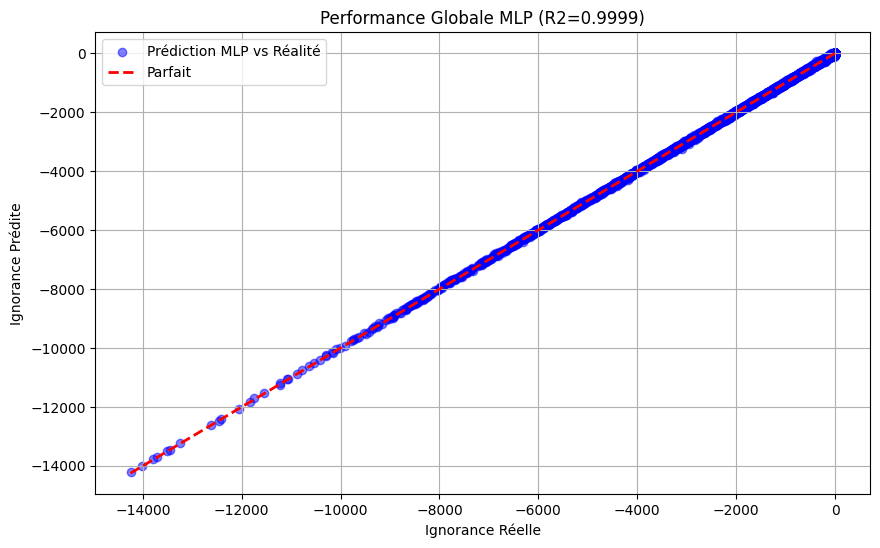

In [80]:
# --- CELLULE 4 : Scatter Plot ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
subset = np.random.choice(len(y_test), 10000, replace=False)

plt.scatter(y_test[subset], y_pred_mlp[subset], alpha=0.5, color='blue', label='Prédiction MLP vs Réalité')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Parfait')

plt.title(f"Performance Globale MLP (R2={r2_mlp:.4f})")
plt.xlabel("Ignorance Réelle")
plt.ylabel("Ignorance Prédite")
plt.legend()
plt.grid(True)
plt.show()

In [85]:
# --- CELLULE 5 : Validation sur une Trajectoire Inédite ---
import plotly.graph_objects as go

# 1. On s'assure que les données de visualisation (scénario inédit) sont prêtes
# (Au cas où vous relanceriez cette cellule seule)
v_visu, g_visu, f_visu = 45, 0.15, 0.003
t_visu = np.linspace(0, 600, 600)
X_visu = np.column_stack((t_visu, np.full_like(t_visu, v_visu), np.full_like(t_visu, g_visu), np.full_like(t_visu, f_visu)))
gen_visu = Generateur_Donnees(v_visu, g_visu, f_visu) # Assurez-vous que votre classe accepte ces params dans le constructeur ou via set
gen_visu.set_vitesse_initiale(v_visu); gen_visu.set_pesanteur(g_visu); gen_visu.set_frottement_visqueux(f_visu)
pos_v_visu = gen_visu.position_virtuelle(t_visu)
pos_r_visu = gen_visu.position_reelle(t_visu)

# 2. Prédiction
ignorance_pred_visu_mlp = best_model_mlp.predict(X_visu)
ignorance_pred_visu_mlp = np.minimum(ignorance_pred_visu_mlp, 0)
pos_hybride_visu_mlp = np.maximum(pos_v_visu + ignorance_pred_visu_mlp,0)

# 3. Plot
fig_mlp = go.Figure()
fig_mlp.add_trace(go.Scatter(x=t_visu, y=pos_v_visu, name="Virtuel", line=dict(dash='dash', color='blue')))
fig_mlp.add_trace(go.Scatter(x=t_visu, y=pos_r_visu, name="Réel (Target)", line=dict(color='green', width=4), opacity=0.4))
fig_mlp.add_trace(go.Scatter(x=t_visu, y=pos_hybride_visu_mlp, name=f"Hybride (MLP)", line=dict(dash='dot', color='red')))

fig_mlp.update_layout(title=f"Test de Généralisation MLP : Scénario Inédit", xaxis_title="Temps (s)", yaxis_title="Position (m)")
fig_mlp.show()

In [83]:
# --- CELLULE 6 : Ignorance sur Scénario Inédit ---

fig_ign_mlp = go.Figure()

# Ignorance Réelle
ignorance_reelle_visu = pos_r_visu - pos_v_visu

fig_ign_mlp.add_trace(go.Scatter(
    x=t_visu,
    y=ignorance_reelle_visu,
    name="Ignorance Réelle",
    line=dict(color='red', width=4),
    opacity=0.5
))

# Ignorance Prédite
fig_ign_mlp.add_trace(go.Scatter(
    x=t_visu,
    y=ignorance_pred_visu_mlp,
    name="Ignorance Prédite (MLP)",
    line=dict(dash='dot', color='blue', width=2)
))

fig_ign_mlp.update_layout(
    title=f"Zoom sur l'Ignorance MLP (Scénario Inédit)",
    xaxis_title="Temps (s)",
    yaxis_title="Ignorance (m)",
    hovermode="x unified"
)
fig_ign_mlp.show()

Comparaison

In [86]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- 1. DÉFINITION DES 3 SCÉNARIOS ---
# On choisit des cas très différents pour tester la robustesse
scenarios = [
    {"v": 20, "g": 0.1, "f": 0.001, "titre": "Cas 1 : Standard"},        # Le cas classique
    {"v": 50, "g": 0.2, "f": 0.005, "titre": "Cas 2 : Haute Vitesse"},   # Ça bouge vite, frottement fort
    {"v": 15, "g": 0.05, "f": 0.008, "titre": "Cas 3 : Chute Lente"}     # Faible gravité mais "air" très épais
]

# --- 2. LISTE DES MODÈLES ---
# On met tes 3 modèles entraînés dans une liste pour boucler dessus
# Assure-toi que best_model_poly, best_model_xgb, best_model_mlp sont bien en mémoire
modeles = [
    ("Polynomial", best_model_poly),
    ("XGBoost", best_model_xgb),
    ("MLP (Neurones)", best_model_mlp)
]

# --- 3. CRÉATION DE LA FIGURE (GRILLE 3x3) ---
fig = make_subplots(
    rows=3, cols=3,
    subplot_titles=[f"{scen['titre']} - {mod[0]}" for scen in scenarios for mod in modeles],
    vertical_spacing=0.1,
    horizontal_spacing=0.05
)

print("Génération des prédictions et construction des graphiques...")

# Boucle sur les Scénarios (Lignes)
for i, scen in enumerate(scenarios):
    row = i + 1

    # Génération de la physique pour ce scénario
    # On recrée un générateur local pour être sûr
    gen_temp = Generateur_Donnees()
    gen_temp.set_vitesse_initiale(scen["v"])
    gen_temp.set_pesanteur(scen["g"])
    gen_temp.set_frottement_visqueux(scen["f"])

    t_visu = np.linspace(0, 800, 800) # Temps de simulation
    pos_v = gen_temp.position_virtuelle(t_visu)
    pos_r = gen_temp.position_reelle(t_visu)
    ignorance_reelle = pos_r - pos_v # Cible

    # Création de la matrice X pour la prédiction [t, v, g, f]
    X_input = np.column_stack((
        t_visu,
        np.full_like(t_visu, scen["v"]),
        np.full_like(t_visu, scen["g"]),
        np.full_like(t_visu, scen["f"])
    ))

    # Boucle sur les Modèles (Colonnes)
    for j, (nom_modele, modele) in enumerate(modeles):
        col = j + 1

        # A. Prédiction
        pred_brute = modele.predict(X_input)

        # B. Contrainte Physique (Magie ici !)
        # On force tout ce qui est positif à devenir 0
        pred_contrainte = np.minimum(pred_brute, 0)

        # C. Tracé Ignorance Réelle (Rouge)
        # On ne l'affiche dans la légende que pour le premier graph pour ne pas polluer
        show_legend = (row == 1 and col == 1)

        fig.add_trace(go.Scatter(
            x=t_visu, y=ignorance_reelle,
            mode='lines', line=dict(color='red', width=3), opacity=0.5,
            name='Ignorance Réelle', showlegend=show_legend
        ), row=row, col=col)

        # D. Tracé Ignorance Prédite (Bleu pointillé)
        fig.add_trace(go.Scatter(
            x=t_visu, y=pred_contrainte,
            mode='lines', line=dict(color='blue', width=2, dash='dot'),
            name=f'Préd {nom_modele}', showlegend=show_legend
        ), row=row, col=col)

# --- 4. MISE EN FORME FINALE ---
fig.update_layout(
    height=900, width=1200,
    title_text="Comparatif Global : Réalité vs Prédiction (avec Contrainte min(y,0))",
    template="plotly_white",
    showlegend=True
)

fig.show()

Génération des prédictions et construction des graphiques...
